In [1]:
import os
import sys
from collections import defaultdict
from functools import reduce, partial

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from pymutspec.annotation import CodonAnnotation
from pymutspec.constants import possible_codons

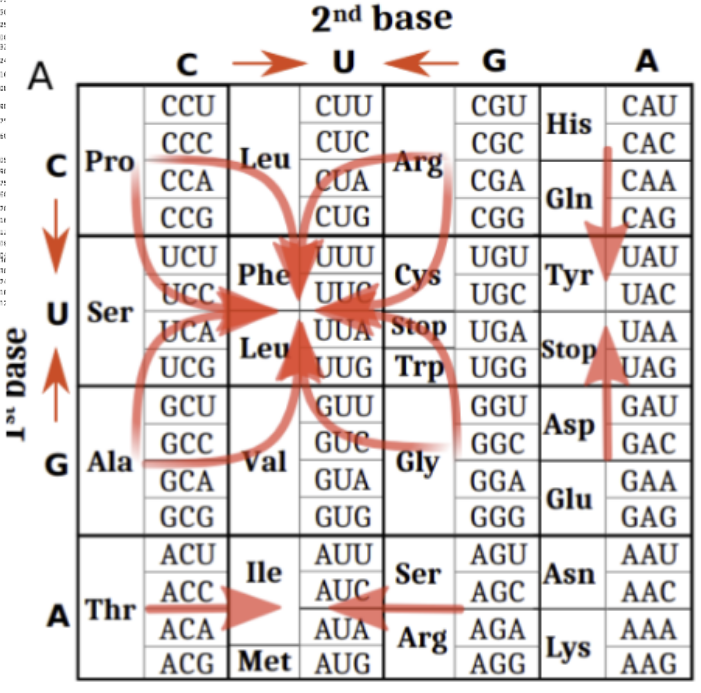

In [2]:
coda = CodonAnnotation(2)

In [3]:
coda.translate_codon('CCA')

'P'

In [4]:
nucls = list('ACGT')
i = 1
data = []
for cdn1 in possible_codons:
    aa1 = coda.translate_codon(cdn1)
    for pic in range(3):
        nuc1 = cdn1[pic]
        for nuc2 in nucls:
            if nuc1 == nuc2:
                continue
            cdn2 = list(cdn1)
            cdn2[pic] = nuc2
            cdn2 = ''.join(cdn2)
            aa2 = coda.translate_codon(cdn2)
            is_syn = aa1 == aa2
            sbs = f'{nuc1}>{nuc2}'
            data.append((pic, cdn1, cdn2, aa1, aa2, is_syn, sbs))
            i += 1
df_changes = pd.DataFrame(data, columns=['pic', 'cdn1', 'cdn2', 'aa1', 'aa2', 'is_syn', 'sbs'])
df_changes

,pic,cdn1,cdn2,aa1,aa2,is_syn,sbs
0,0,AAA,CAA,K,Q,False,A>C
1,0,AAA,GAA,K,E,False,A>G
2,0,AAA,TAA,K,*,False,A>T
3,1,AAA,ACA,K,T,False,A>C
4,1,AAA,AGA,K,*,False,A>G
...,...,...,...,...,...,...,...
571,1,TTT,TCT,F,S,False,T>C
572,1,TTT,TGT,F,C,False,T>G
573,2,TTT,TTA,F,L,False,T>A
574,2,TTT,TTC,F,F,True,T>C


In [5]:
with_stop = df_changes[(df_changes.aa1 == '*') | (df_changes.aa2 == '*')]
with_stop

,pic,cdn1,cdn2,aa1,aa2,is_syn,sbs
2,0,AAA,TAA,K,*,False,A>T
4,1,AAA,AGA,K,*,False,A>G
20,0,AAG,TAG,K,*,False,A>T
22,1,AAG,AGG,K,*,False,A>G
40,1,ACA,AGA,T,*,False,C>G
...,...,...,...,...,...,...,...
507,1,TGA,TAA,W,*,False,G>A
522,0,TGG,AGG,W,*,False,T>A
525,1,TGG,TAG,W,*,False,G>A
543,1,TTA,TAA,L,*,False,T>A


In [6]:
df_changes_flt = df_changes[(df_changes.aa1 != '*') & (df_changes.aa2 != '*')].copy()
df_changes_flt

,pic,cdn1,cdn2,aa1,aa2,is_syn,sbs
0,0,AAA,CAA,K,Q,False,A>C
1,0,AAA,GAA,K,E,False,A>G
3,1,AAA,ACA,K,T,False,A>C
5,1,AAA,ATA,K,M,False,A>T
6,2,AAA,AAC,K,N,False,A>C
...,...,...,...,...,...,...,...
571,1,TTT,TCT,F,S,False,T>C
572,1,TTT,TGT,F,C,False,T>G
573,2,TTT,TTA,F,L,False,T>A
574,2,TTT,TTC,F,F,True,T>C


In [7]:
df_changes_flt.is_syn.value_counts()

False    380
True     128
Name: is_syn, dtype: int64

In [8]:
df_changes_flt.aa1.value_counts()

L    52
S    48
V    36
A    36
P    36
T    34
G    34
R    34
D    18
C    18
F    18
N    18
H    18
I    18
E    16
Q    16
M    16
Y    14
W    14
K    14
Name: aa1, dtype: int64

In [9]:
df_changes_flt.aa2.value_counts()

L    52
S    48
V    36
P    36
A    36
G    34
T    34
R    34
I    18
F    18
N    18
H    18
D    18
C    18
Q    16
E    16
M    16
Y    14
K    14
W    14
Name: aa2, dtype: int64

**Some substitutions are less probable due to effect of mutations:**

**C>T never make stop-loss or stop-gains**

In [10]:
df_changes_flt.sbs.value_counts()

C>T    46
T>C    46
C>G    44
G>C    44
A>C    42
C>A    42
G>T    42
T>G    42
A>G    40
A>T    40
G>A    40
T>A    40
Name: sbs, dtype: int64

## Prepare amino acid transition matrix

In [11]:
# load Kelley Harris spectra
ms12 = pd.read_csv('../data/external/rates_by_clade.csv')
ms12 = ms12[ms12.clade == '20A'].copy()
ms12['mut_type'] = ms12['mut_type'].str.replace('to', '>')
ms12['rate_my'] = ms12['count'] / ms12['total_count'] / ms12['parent_nt_frac']
ms12

,clade,mut_type,count,total_count,fraction,parent_nt,parent_nt_frac,rate,rate_my
0,20A,A>C,286,17202,0.016626,A,0.289620,0.057407,0.057406
1,20A,A>G,1617,17202,0.094001,A,0.289620,0.324570,0.324566
2,20A,A>T,515,17202,0.029938,A,0.289620,0.103370,0.103371
3,20A,C>A,339,17202,0.019707,C,0.137040,0.143810,0.143805
4,20A,C>G,130,17202,0.007557,C,0.137040,0.055147,0.055146
5,20A,C>T,7113,17202,0.413500,C,0.137040,3.017400,3.017356
6,20A,G>A,837,17202,0.048657,G,0.064987,0.748720,0.748721
7,20A,G>C,137,17202,0.007964,G,0.064987,0.122550,0.122551
8,20A,G>T,2670,17202,0.155210,G,0.064987,2.388400,2.388393
9,20A,T>A,565,17202,0.032845,T,0.508360,0.064610,0.064610


In [88]:
sbs2rate = ms12.set_index('mut_type')['rate'].to_dict()

In [89]:
df_changes['rate'] = df_changes['sbs'].map(sbs2rate)

df_changes_flt['rate'] = df_changes_flt['sbs'].map(sbs2rate)
df_changes_flt

,pic,cdn1,cdn2,aa1,aa2,is_syn,sbs,rate
0,0,AAA,CAA,K,Q,False,A>C,0.057407
1,0,AAA,GAA,K,E,False,A>G,0.324570
3,1,AAA,ACA,K,T,False,A>C,0.057407
5,1,AAA,ATA,K,M,False,A>T,0.103370
6,2,AAA,AAC,K,N,False,A>C,0.057407
...,...,...,...,...,...,...,...,...
571,1,TTT,TCT,F,S,False,T>C,0.297090
572,1,TTT,TGT,F,C,False,T>G,0.045170
573,2,TTT,TTA,F,L,False,T>A,0.064610
574,2,TTT,TTC,F,F,True,T>C,0.297090


In [16]:
# aa_rate_matrix = df_changes_flt.groupby(['aa1', 'aa2'])['rate'].sum().unstack().fillna(0.).T
# aa_rate_matrix

In [17]:
# d = aa_rate_matrix.values.sum(axis=0)
# d

## Eigenvalues

Equilibrium Frequencies of SARS-CoV-2 Nucleotides

The predicted equilibrium frequencies of nucleotides shown in figure 3A were calculated as the real component of the principal eigenvector of a rate matrix constructed from the relative rates of each mutation type for that clade.

https://doi.org/10.1093/molbev/msad085

https://github.com/jbloomlab/SARS2-mut-spectrum/blob/main/scripts/equilibrium_frequencies.py

In [80]:
alphabet = 'ACGT'

def nuc_spectrum_to_matrix(spec):
    '''
    convert dictionary of mutation counts to mutation matrix
    '''
    M = np.zeros((4,4))
    for i1,n1 in enumerate(alphabet):
        for i2,n2 in enumerate(alphabet):
            if n1!=n2:
                M[i2,i1] = spec[f"{n1}>{n2}"]
    # normalize off-diagonal rates (just for standardization, doesn't affect the results)
    M /= M.sum()
    # # will the diagonal with 'outflow' term to guarantee conservation of probability
    d = M.sum(axis=0)
    np.fill_diagonal(M,-d)

    return M

aa_alphabet = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 
               'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']


def aa_spectrum_to_matrix(aa_sbs):
    '''
    convert dictionary of mutation counts to mutation matrix
    '''
    n = len(aa_alphabet)
    M = np.zeros((n, n))
    for i1,aa1 in enumerate(aa_alphabet):
        for i2,aa2 in enumerate(aa_alphabet):
            if aa1!=aa2:
                val = aa_sbs[(aa1, aa2)] if (aa1, aa2) in aa_sbs.index else 0.
                M[i2,i1] = val
    # normalize off-diagonal rates (just for standardization, doesn't affect the results)
    M /= M.sum()
    # will the diagonal with 'outflow' term to guarantee conservation of probability
    d = M.sum(axis=0)
    np.fill_diagonal(M,-d)

    return M

def cdn_spectrum_to_matrix(cdn_sbs):
    '''
    convert dictionary of mutation counts to mutation matrix
    '''
    n = len(possible_codons)
    M = np.zeros((n, n))
    for i1,cdn1 in enumerate(possible_codons):
        for i2,cdn2 in enumerate(possible_codons):
            if cdn1!=cdn2:
                val = cdn_sbs[(cdn1, cdn2)] if (cdn1, cdn2) in cdn_sbs.index else 0.
                M[i2,i1] = val
    # normalize off-diagonal rates (just for standardization, doesn't affect the results)
    M /= M.sum()
    # will the diagonal with 'outflow' term to guarantee conservation of probability
    d = M.sum(axis=0)
    np.fill_diagonal(M,-d)

    return M

def get_equilibrium_probabilities(M):
    evals, evecs = np.linalg.eig(M)
    # find zero eigenvalue
    ii = np.argmin(np.abs(evals))
    assert np.abs(evals[ii])<1e-10
    # pull out corresponding eigenvector, return normalized to sum_i p_i = 1
    p = evecs[:,ii]
    return p/p.sum()

[0.16219871 0.07212197 0.02759827 0.73808105]


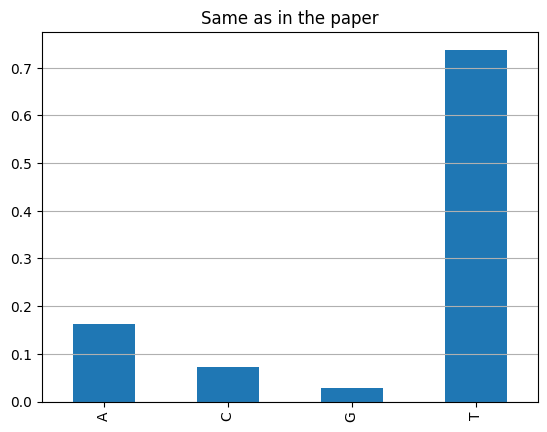

In [82]:
M = nuc_spectrum_to_matrix(sbs2rate)
eq_prob = get_equilibrium_probabilities(M).astype(float)
print(eq_prob)
pd.Series(dict(zip(alphabet, eq_prob))).plot.bar()
# plt.yticks(np.linspace(0, 0.5, 21));
plt.grid(axis='y');
plt.title('Same as in the paper');

/tmp/ipykernel_151388/1005261906.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  eq_prob = get_equilibrium_probabilities(M).astype(float)


[0.00145503 0.01924134 0.00659078 0.00202912 0.45167746 0.00098729
 0.01291594 0.17607191 0.00699721 0.06031316 0.03797714 0.04609654
 0.00394698 0.00408313 0.00152259 0.02030378 0.01021544 0.01549699
 0.00328631 0.11879186]


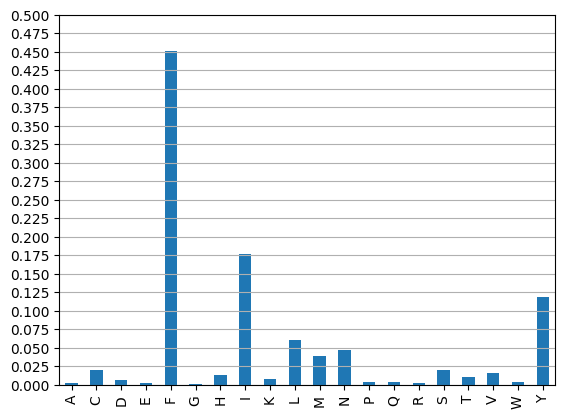

In [121]:
aa_sbs = df_changes_flt.groupby(['aa1', 'aa2'])['rate'].sum()
M = aa_spectrum_to_matrix(aa_sbs)
eq_prob = get_equilibrium_probabilities(M).astype(float)
print(eq_prob)
eq_freqs_aa = pd.Series(dict(zip(aa_alphabet, eq_prob)))
eq_freqs_aa.plot.bar()
plt.yticks(np.linspace(0, 0.5, 21));
plt.grid(axis='y');

In [115]:
cdn_sbs = df_changes.groupby(['cdn1', 'cdn2'])['rate'].sum()
M = cdn_spectrum_to_matrix(cdn_sbs)
eq_prob = get_equilibrium_probabilities(M).astype(float)

eq_freqs = pd.Series(dict(zip(possible_codons, eq_prob)))
eq_freqs.name = 'freq'
eq_freqs.index.name = 'cdn'
eq_freqs = eq_freqs.reset_index()
eq_freqs['aa'] = eq_freqs['cdn'].map(coda.translate_codon)
eq_freqs.to_csv('../data/equilibrium_freqs_20A.csv', index=False)
eq_freqs.sort_values('freq')

,cdn,freq,aa
42,GGG,0.000021,G
38,GCG,0.000055,A
41,GGC,0.000055,G
26,CGG,0.000055,R
10,AGG,0.000124,*
...,...,...,...
55,TCT,0.039289,S
15,ATT,0.088360,I
51,TAT,0.088360,Y
60,TTA,0.088360,L


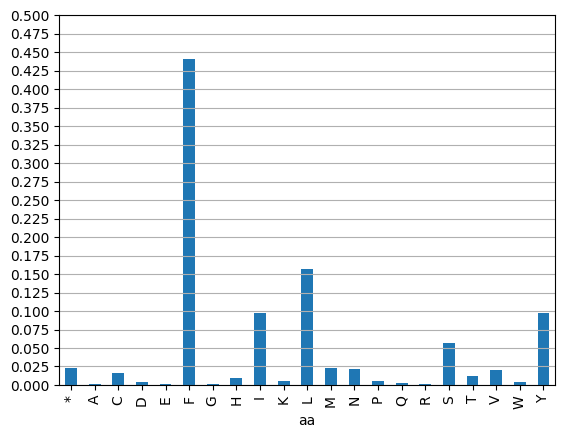

In [125]:
# plt.figure(figsize=(12, 6))
plt.yticks(np.linspace(0, 0.4, 17));
eq_freqs_aa_new = eq_freqs.groupby('aa').freq.sum()
eq_freqs_aa_new.plot.bar()
plt.yticks(np.linspace(0, 0.5, 21));
plt.grid(axis='y');

In [141]:
freqs_diff = pd.concat([eq_freqs_aa.rename('based_on_aa'), 
                        eq_freqs_aa_new.rename('based_on_cdn')], axis=1).fillna(0.)
freqs_diff['based_on_cdn_adj'] = freqs_diff['based_on_cdn']
freqs_diff.loc['*', 'based_on_cdn_adj'] = 0.
freqs_diff['based_on_cdn_adj'] /= freqs_diff['based_on_cdn_adj'].sum()
freqs_diff['diff'] = freqs_diff['based_on_aa'] - freqs_diff['based_on_cdn']
freqs_diff['diff_adj'] = freqs_diff['based_on_aa'] - freqs_diff['based_on_cdn_adj']
freqs_diff['high'] = freqs_diff['diff'].abs() > 0.01
freqs_diff['high_adj'] = freqs_diff['diff_adj'].abs() > 0.01
freqs_diff[freqs_diff.high]

,based_on_aa,based_on_cdn,based_on_cdn_adj,diff,diff_adj,high,high_adj
F,0.451677,0.441369,0.452024,0.010308,-0.000346,True,False
I,0.176072,0.096994,0.099336,0.079078,0.076736,True,True
L,0.060313,0.156626,0.160407,-0.096313,-0.100094,True,True
M,0.037977,0.022722,0.023270,0.015255,0.014707,True,True
N,0.046097,0.021315,0.021830,0.024781,0.024267,True,True
S,0.020304,0.056859,0.058231,-0.036555,-0.037927,True,True
Y,0.118792,0.096994,0.099336,0.021798,0.019456,True,True
*,0.000000,0.023571,0.000000,-0.023571,0.000000,True,False


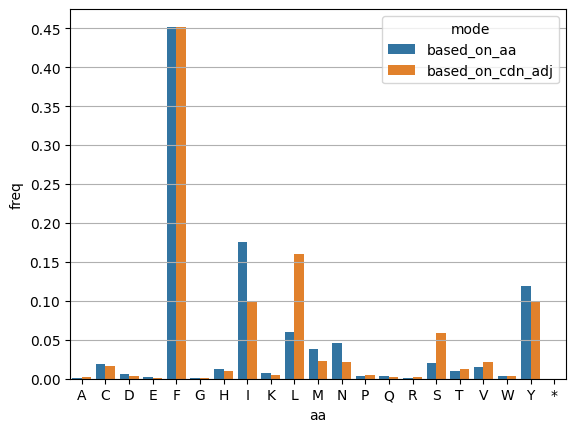

In [157]:
cols = ['based_on_aa', 'based_on_cdn_adj']
freqs_diff_long = freqs_diff[cols].stack().reset_index()
freqs_diff_long.columns = ['aa', 'mode', 'freq']
sns.barplot(freqs_diff_long, x='aa', y='freq', hue='mode')
plt.yticks(np.linspace(0, 0.45, 10));
plt.grid(axis='y');